In [14]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.neighbors import DistanceMetric
from math import radians
import folium
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points
import matplotlib.pyplot as plt

# Acessando arquivos 

In [15]:
junho = pd.read_excel("/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Output de dados/viagens_validas_junho.xlsx", index_col='Unnamed: 0')
#junho.rename(columns={'index': 'index_col'}, inplace = True)
junho['index_col'] = None
junho.loc[junho.dataInicio.dt.month == 6, 'index_col'] = junho['index_col'].astype(str) + '_' + junho.dataInicio.dt.month.astype(str)

julho = pd.read_excel("/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Output de dados/viagens_validas_julho.xlsx", index_col='Unnamed: 0')
#julho.rename(columns={'index': 'index_col'}, inplace = True)
julho['index_col'] = None
julho.loc[julho.dataInicio.dt.month == 7, 'index_col'] = julho['index_col'].astype(str) + '_' + julho.dataInicio.dt.month.astype(str)

agosto = pd.read_excel("/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Output de dados/viagens_validas_agosto.xlsx", index_col='Unnamed: 0')
#agosto.rename(columns={'index': 'index_col'}, inplace = True)
agosto['index_col'] = None
agosto.loc[agosto.dataInicio.dt.month == 8, 'index_col'] = agosto['index_col'].astype(str) + '_' + agosto.dataInicio.dt.month.astype(str)

viagens_validas = pd.concat([junho, julho, agosto], axis = 0)

viagens_validas

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,index_col
0,0,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,None_6
1,1,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,None_6
2,2,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,None_6
3,3,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,None_6
4,4,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,None_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,6010,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None_8
6011,6011,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None_8
6012,6012,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,None_8
6013,6013,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,None_8


In [16]:
viagens_validas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16546 entries, 0 to 6014
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        16546 non-null  int64         
 1   day          16546 non-null  int64         
 2   device_id    16546 non-null  int64         
 3   periodo      16546 non-null  object        
 4   dataInicio   16546 non-null  datetime64[ns]
 5   dataFim      16546 non-null  datetime64[ns]
 6   sequence     16546 non-null  int64         
 7   distance(m)  16546 non-null  float64       
 8   duration(s)  16546 non-null  float64       
 9   latitudeI    16546 non-null  float64       
 10  longitudeI   16546 non-null  float64       
 11  latitudeF    16546 non-null  float64       
 12  longitudeF   16546 non-null  float64       
 13  index_col    16546 non-null  object        
dtypes: datetime64[ns](2), float64(6), int64(4), object(2)
memory usage: 1.9+ MB


# Mapeamento da OD de cada viagem


In [17]:
paradas_eletrico_inicio = pd.read_excel("/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/ponto_de_onibus.xlsx")
paradas_eletrico_inicio.rename(columns={'Ponto': 'PontoInicial'}, inplace = True)
paradas_eletrico_inicio.rename(columns={'Ordem': 'OrdemChegada'}, inplace = True)
paradas_eletrico_inicio
paradas_eletrico_final = pd.read_excel("/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/ponto_de_onibus.xlsx")
paradas_eletrico_final.rename(columns={'Ordem': 'OrdemSaida'}, inplace = True)
paradas_eletrico_final.rename(columns={'Ponto': 'PontoFinal'}, inplace = True)
paradas_eletrico_final

,PontoFinal,OrdemSaida,Lat,Long,Densidade
0,1,FEC / RS,-22.815664,-47.062650,175527.01560
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281
7,8,CECI Berçário / FEA,-22.821001,-47.068121,91303.71094
8,9,IB / SIARQ,-22.819147,-47.072227,86938.40625
9,10,IQ / FEA,-22.819335,-47.067119,75935.28125


In [18]:
gpd1 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeI, viagens_validas.latitudeI))
gpd2 = gpd.GeoDataFrame(paradas_eletrico_inicio, geometry=gpd.points_from_xy(paradas_eletrico_inicio.Long, paradas_eletrico_inicio.Lat))

gpd4 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeF, viagens_validas.latitudeF))
gpd5 = gpd.GeoDataFrame(paradas_eletrico_final, geometry=gpd.points_from_xy(paradas_eletrico_final.Long, paradas_eletrico_final.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

gpd3=ckdnearest(gpd1, gpd2)

gpd4 = gpd.GeoDataFrame(viagens_validas, geometry=gpd.points_from_xy(viagens_validas.longitudeF, viagens_validas.latitudeF))
gpd5 = gpd.GeoDataFrame(paradas_eletrico_final, geometry=gpd.points_from_xy(paradas_eletrico_final.Long, paradas_eletrico_final.Lat))


def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf


gpd6=ckdnearest(gpd4, gpd5)



In [19]:
gpd3

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,...,latitudeF,longitudeF,index_col,geometry,PontoInicial,OrdemChegada,Lat,Long,Densidade,dist
0,0,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,...,-22.829708,-47.060686,None_6,POINT (-47.06069 -22.82971),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.000691
1,1,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,...,-22.827097,-47.061306,None_6,POINT (-47.06131 -22.82710),35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,0.000065
2,2,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,...,-22.828888,-47.060592,None_6,POINT (-47.06059 -22.82889),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001064
3,3,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,...,-22.828920,-47.060559,None_6,POINT (-47.06056 -22.82892),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001067
4,4,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,...,-22.831784,-47.062191,None_6,POINT (-47.06219 -22.83178),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16542,6011,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16543,6012,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16544,6013,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,...,-22.824985,-47.065243,None_8,POINT (-47.06524 -22.82499),11,DGA / Praça das Bandeiras,-22.824862,-47.065478,67135.19531,0.000265


In [20]:
gpd6

,index,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,...,latitudeF,longitudeF,index_col,geometry,PontoFinal,OrdemSaida,Lat,Long,Densidade,dist
0,0,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,...,-22.829708,-47.060686,None_6,POINT (-47.06069 -22.82971),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.000691
1,1,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,...,-22.827097,-47.061306,None_6,POINT (-47.06131 -22.82710),35,Escola Sérgio P. Porto (PONTO FINAL),-22.827112,-47.061369,0.00000,0.000065
2,2,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,...,-22.828888,-47.060592,None_6,POINT (-47.06059 -22.82889),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001064
3,3,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,...,-22.828920,-47.060559,None_6,POINT (-47.06056 -22.82892),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.001067
4,4,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,...,-22.831784,-47.062191,None_6,POINT (-47.06219 -22.83178),30,Hemocentro / FCM,-22.829614,-47.061370,30876.05859,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16541,6010,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16542,6011,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16543,6012,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,...,-22.827759,-47.066974,None_8,POINT (-47.06697 -22.82776),18,CAISM / Portaria 2 - HC,-22.827839,-47.066777,48880.90234,0.000213
16544,6013,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,...,-22.824985,-47.065243,None_8,POINT (-47.06524 -22.82499),11,DGA / Praça das Bandeiras,-22.824862,-47.065478,67135.19531,0.000265


In [22]:
matriz_junho= pd.merge(gpd3, gpd6,how = 'inner' , on = [ 'index_col','day', 'device_id', 'periodo', 'sequence', 'distance(m)', 'duration(s)', 'dataInicio', 'dataFim','latitudeI', 'longitudeI', 'latitudeF', 'longitudeF'])
matriz_junho = matriz_junho[['index_col','day', 'device_id', 'periodo', 'dataInicio', 'dataFim', 'sequence', 'distance(m)',
       'duration(s)', 'latitudeI', 'longitudeI', 'latitudeF', 'longitudeF', 'OrdemSaida', 'OrdemChegada',
       'PontoFinal',  'dist_x','PontoInicial', 'dist_y']]

matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,OrdemSaida,OrdemChegada,PontoFinal,dist_x,PontoInicial,dist_y
0,None_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,Hemocentro / FCM,Hemocentro / FCM,30,0.000691,30,0.000691
1,None_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,Escola Sérgio P. Porto (PONTO FINAL),Escola Sérgio P. Porto (PONTO FINAL),35,0.000065,35,0.000065
2,None_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,Hemocentro / FCM,Hemocentro / FCM,30,0.001064,30,0.001064
3,None_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,Hemocentro / FCM,Hemocentro / FCM,30,0.001067,30,0.001067
4,None_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,Hemocentro / FCM,Hemocentro / FCM,30,0.002320,30,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16856,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16857,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16858,None_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,DGA / Praça das Bandeiras,DGA / Praça das Bandeiras,11,0.000265,11,0.000265


In [23]:
matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,OrdemSaida,OrdemChegada,PontoFinal,dist_x,PontoInicial,dist_y
0,None_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,Hemocentro / FCM,Hemocentro / FCM,30,0.000691,30,0.000691
1,None_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,Escola Sérgio P. Porto (PONTO FINAL),Escola Sérgio P. Porto (PONTO FINAL),35,0.000065,35,0.000065
2,None_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,Hemocentro / FCM,Hemocentro / FCM,30,0.001064,30,0.001064
3,None_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,Hemocentro / FCM,Hemocentro / FCM,30,0.001067,30,0.001067
4,None_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,Hemocentro / FCM,Hemocentro / FCM,30,0.002320,30,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16856,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16857,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,18,0.000213,18,0.000213
16858,None_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,DGA / Praça das Bandeiras,DGA / Praça das Bandeiras,11,0.000265,11,0.000265


In [24]:
matriz_junho_agrupada=matriz_junho.groupby(by=[matriz_junho.dataInicio.dt.month,matriz_junho.day, matriz_junho.periodo,'PontoInicial','PontoFinal']).agg({'sequence': 'count'}).reset_index()

matriz_junho_agrupada

,dataInicio,day,periodo,PontoInicial,PontoFinal,sequence
0,6,1,Manha,1,1,1
1,6,1,Manha,2,2,1
2,6,1,Manha,6,6,3
3,6,1,Manha,7,7,2
4,6,1,Manha,8,8,4
...,...,...,...,...,...,...
3567,8,31,Tarde,28,28,3
3568,8,31,Tarde,29,29,3
3569,8,31,Tarde,30,30,4
3570,8,31,Tarde,32,32,1


In [25]:
pivotttt = matriz_junho_agrupada[   (matriz_junho_agrupada['dataInicio'] == 6)  &
                                    (matriz_junho_agrupada['day'] == 1)         &
                                    (matriz_junho_agrupada['periodo'] == 'Tarde')].pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
pivotttt

PontoFinal,1,2,3,4,6,7,8,10,11,12,...,21,22,24,26,28,29,30,32,33,34
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
matriz_junho_agrupada=matriz_junho.groupby(by=['day','PontoInicial','PontoFinal']).count()
matriz_junho_agrupada

index_col  device_id  periodo  dataInicio  \
day PontoInicial PontoFinal                                              
1   1            1                  10         10       10          10   
    2            2                  19         19       19          19   
    3            3                   7          7        7           7   
    4            4                   2          2        2           2   
    6            6                  18         18       18          18   
...                                ...        ...      ...         ...   
31  30           30                 16         16       16          16   
    31           31                  1          1        1           1   
    32           32                  2          2        2           2   
    33           33                  6          6        6           6   
    34           34                  1          1        1           1   

                             dataFim  sequence  distance(m)  duration(s)  \
day PontoInicial PontoFinal                                                
1   1            1                10        10           10           10   
    2            2                19        19           19           19   
    3            3                 7         7            7            7   
    4            4                 2         2            2            2   
    6            6                18        18           18           18   
...                              ...       ...          ...          ...   
31  30           30               16        16           16           16   
    31           31                1         1            1            1   
    32           32                2         2            2            2   
    33           33                6         6            6            6   
    34           34                1         1            1            1   

                             latitudeI  longitudeI  latitudeF  longitudeF  \
day PontoInicial PontoFinal                                                 
1   1            1                  10          10         10          10   
    2            2                  19          19         19          19   
    3            3                   7           7          7           7   
    4            4                   2           2          2           2   
    6            6                  18          18         18          18   
...                                ...         ...        ...         ...   
31  30           30                 16          16         16          16   
    31           31                  1           1          1           1   
    32           32                  2           2          2           2   
    33           33                  6           6          6           6   
    34           34                  1           1          1           1   

                             OrdemSaida  OrdemChegada  dist_x  dist_y  
day PontoInicial PontoFinal                                            
1   1            1                   10            10      10      10  
    2            2                   19            19      19      19  
    3            3                    7             7       7       7  
    4            4                    2             2       2       2  
    6            6                   18            18      18      18  
...                                 ...           ...     ...     ...  
31  30           30                  16            16      16      16  
    31           31                   1             1       1       1  
    32           32                   2             2       2       2  
    33           33                   6             6       6       6  
    34           34                   1             1       1       1  

[1015 rows x 16 columns]

In [27]:
matriz_junho_1=matriz_junho.loc[matriz_junho['day']==1]
matriz_junho_1
# matriz_junho_1.to_excel('matriz_junho_agrupada_1.xlsx', index = False)

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,OrdemSaida,OrdemChegada,PontoFinal,dist_x,PontoInicial,dist_y
0,None_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,Hemocentro / FCM,Hemocentro / FCM,30,0.000691,30,0.000691
1,None_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,Escola Sérgio P. Porto (PONTO FINAL),Escola Sérgio P. Porto (PONTO FINAL),35,0.000065,35,0.000065
2,None_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,Hemocentro / FCM,Hemocentro / FCM,30,0.001064,30,0.001064
3,None_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,Hemocentro / FCM,Hemocentro / FCM,30,0.001067,30,0.001067
4,None_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,Hemocentro / FCM,Hemocentro / FCM,30,0.002320,30,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,None_7,1,4222,Tarde,2021-07-01 18:35:41,2021-07-01 18:40:24,1,449.993315,283.0,-22.828609,-47.066269,-22.825300,-47.065551,DGA / Praça das Bandeiras,DGA / Praça das Bandeiras,11,0.000444,11,0.000444
5105,None_7,1,4305,Tarde,2021-07-01 18:43:30,2021-07-01 18:47:04,1,366.536299,214.0,-22.820078,-47.065609,-22.818040,-47.063608,CCUEC / CENAPAD,CCUEC / CENAPAD,29,0.000525,29,0.000525
5106,None_7,1,4374,Tarde,2021-07-01 19:04:38,2021-07-01 19:20:01,1,408.467081,923.0,-22.814343,-47.067751,-22.814191,-47.064432,NEPP / IC,NEPP / IC,6,0.000663,6,0.000663
5107,None_7,1,4417,Tarde,2021-07-01 19:09:43,2021-07-01 19:16:30,1,485.392237,407.0,-22.827591,-47.067245,-22.824011,-47.067959,Reitoria II / GGBS,Reitoria II / GGBS,17,0.000320,17,0.000320


# Resolvendo o p-Medianas

In [28]:
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer

In [29]:
matriz_junho.head(15)

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,OrdemSaida,OrdemChegada,PontoFinal,dist_x,PontoInicial,dist_y
0,None_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,Hemocentro / FCM,Hemocentro / FCM,30,0.000691,30,0.000691
1,None_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,Escola Sérgio P. Porto (PONTO FINAL),Escola Sérgio P. Porto (PONTO FINAL),35,0.000065,35,0.000065
2,None_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,Hemocentro / FCM,Hemocentro / FCM,30,0.001064,30,0.001064
3,None_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,Hemocentro / FCM,Hemocentro / FCM,30,0.001067,30,0.001067
4,None_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,Hemocentro / FCM,Hemocentro / FCM,30,0.002320,30,0.002320
5,None_6,1,10,Manha,2021-06-01 07:12:06,2021-06-01 12:34:25,5,584.740213,73.0,-22.828233,-47.060820,-22.829112,-47.060477,Hemocentro / FCM,Hemocentro / FCM,30,0.001024,30,0.001024
6,None_6,1,10,Tarde,2021-06-01 13:12:20,2021-06-01 17:05:16,6,774.077323,2797.0,-22.828498,-47.060741,-22.829695,-47.061042,Hemocentro / FCM,Hemocentro / FCM,30,0.000338,30,0.000338
7,None_6,1,15,Tarde,2021-06-01 14:57:28,2021-06-01 16:43:50,2,365.611485,91.0,-22.826819,-47.061479,-22.829299,-47.060340,Hemocentro / FCM,Hemocentro / FCM,30,0.001077,30,0.001077
8,None_6,1,21,Manha,2021-06-01 07:58:35,2021-06-01 12:32:24,3,391.997417,607.0,-22.826375,-47.061788,-22.827425,-47.061065,Escola Sérgio P. Porto (PONTO INICIAL),Escola Sérgio P. Porto (PONTO INICIAL),34,0.000348,34,0.000348
9,None_6,1,21,Tarde,2021-06-01 14:32:37,2021-06-01 16:43:27,4,407.155363,125.0,-22.827339,-47.061163,-22.827882,-47.060964,Escola Sérgio P. Porto (PONTO INICIAL),Escola Sérgio P. Porto (PONTO INICIAL),34,0.000776,34,0.000776


In [30]:
paradas_eletrico_final.head(10)

,PontoFinal,OrdemSaida,Lat,Long,Densidade,geometry
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)
7,8,CECI Berçário / FEA,-22.821001,-47.068121,91303.71094,POINT (-47.06812 -22.82100)
8,9,IB / SIARQ,-22.819147,-47.072227,86938.40625,POINT (-47.07223 -22.81915)
9,10,IQ / FEA,-22.819335,-47.067119,75935.28125,POINT (-47.06712 -22.81933)


In [31]:
# kmedians.__init__	(	 	self, 	data, 	initial_centers, 	tolerance = 0.001, 	ccore = True, 	kwargs )		

# [in]	data	(list): Input data that is presented as list of points (objects), each point should be represented by list or tuple.
# [in]	initial_centers	(list): Initial coordinates of medians of clusters that are represented by list: [center1, center2, ...].
# [in]	tolerance	(double): Stop condition: if maximum value of change of centers of clusters is less than tolerance than algorithm will stop processing
# [in]	ccore	(bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
# [in]	**kwargs	Arbitrary keyword arguments (available arguments: 'metric', 'itermax').

# print(kmedians_instance)

In [32]:
def apply_kmedians(latlong_paradas, latlong_viagens):
    kmedians_instance = kmedians(latlong_viagens, latlong_paradas)
    kmedians_instance.process()
    viagens_por_parada = kmedians_instance.get_clusters()
    pontos_parada = kmedians_instance.get_medians()

    return pontos_parada, viagens_por_parada


In [33]:
pontos_parada_antes = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)]), ['Lat','Long']].values.tolist()
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)])]

,PontoFinal,OrdemSaida,Lat,Long,Densidade,geometry
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)


In [34]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()

In [38]:
pontos_parada, viagens_por_parada = apply_kmedians(pontos_parada_antes, pontos_viagens)

In [39]:
print(len(viagens_por_parada))
for num in range(len(viagens_por_parada)):
    
    print(num, 'ponto de parada ',pontos_parada[num], 'quantidade de viagens com origem ai',len(viagens_por_parada[num]))#, '\n',clusters[num])

7
0 ponto de parada  [-22.8138765, -47.060266] quantidade de viagens com origem ai 76
1 ponto de parada  [-22.816292, -47.072626] quantidade de viagens com origem ai 24
2 ponto de parada  [-22.813392, -47.064553] quantidade de viagens com origem ai 3
3 ponto de parada  [-22.817006, -47.066196] quantidade de viagens com origem ai 9
4 ponto de parada  [-22.813829, -47.069355] quantidade de viagens com origem ai 7
5 ponto de parada  [-22.813263, -47.063559] quantidade de viagens com origem ai 7
6 ponto de parada  [-22.825009, -47.06596] quantidade de viagens com origem ai 239


In [40]:
pontos_onibus = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)]), ['Lat','Long']].values.tolist()
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].isin([i for i in range(8)])]

,PontoFinal,OrdemSaida,Lat,Long,Densidade,geometry
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)


In [41]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()

In [42]:
# kmedians.__init__	(	 	self, 	data, 	initial_centers, 	tolerance = 0.001, 	ccore = True, 	kwargs )		

# [in]	data	(list): Input data that is presented as list of points (objects), each point should be represented by list or tuple.
# [in]	initial_centers	(list): Initial coordinates of medians of clusters that are represented by list: [center1, center2, ...].
# [in]	tolerance	(double): Stop condition: if maximum value of change of centers of clusters is less than tolerance than algorithm will stop processing
# [in]	ccore	(bool): Defines should be CCORE library (C++ pyclustering library) used instead of Python code or not.
# [in]	**kwargs	Arbitrary keyword arguments (available arguments: 'metric', 'itermax').

kmedians_instance = kmedians(pontos_viagens, pontos_onibus)
# print(kmedians_instance)

In [43]:
# Run cluster analysis and obtain results.
kmedians_instance.process()
clusters = kmedians_instance.get_clusters()
medians = kmedians_instance.get_medians()

In [44]:
print(len(clusters))
for num in range(len(clusters)):
    
    print(num, len(clusters[num]), '\n',clusters[num])

7
0 76 
 [4, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83, 84, 85, 107, 108, 109, 123, 141, 142, 147, 148, 157, 166, 167, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 290, 291, 292, 301, 302, 303, 304, 305, 318, 319]
1 24 
 [10, 11, 112, 113, 114, 115, 116, 144, 170, 273, 274, 276, 294, 295, 309, 310, 317, 320, 326, 327, 339, 342, 343, 353]
2 3 
 [80, 143, 268]
3 9 
 [12, 90, 91, 128, 129, 150, 178, 289, 293]
4 7 
 [88, 89, 111, 308, 323, 328, 362]
5 7 
 [60, 61, 82, 87, 134, 243, 300]
6 239 
 [0, 1, 2, 3, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 81, 86, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 110, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 130, 131, 132, 133, 

In [45]:
pontos_viagens = matriz_junho.loc[matriz_junho['day'] == 1, ['latitudeI','longitudeI']].values.tolist()
# print(pontos_viagens)


for num in range(1,37):
    
    print(num, 'N PONTOS DE ONIBUS')
    pontos_parada_antes = paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].index.isin([i for i in range(num)]), ['Lat','Long']].values.tolist()
    print(pontos_parada_antes)
    pontos_parada, viagens_por_parada = apply_kmedians(pontos_parada_antes, pontos_viagens)

    for lensss in range(len(viagens_por_parada)):
    
        print('ponto de onibus --> ',lensss, 'quando pontos tem:',len(viagens_por_parada[lensss]))#, '\n',viagens_por_parada[lensss])


1 N PONTOS DE ONIBUS
[[-22.81566371, -47.06265025]]
ponto de onibus -->  0 quando pontos tem: 365
2 N PONTOS DE ONIBUS
[[-22.81566371, -47.06265025], [-22.81656666, -47.07261734]]
ponto de onibus -->  0 quando pontos tem: 274
ponto de onibus -->  1 quando pontos tem: 91
3 N PONTOS DE ONIBUS
[[-22.81566371, -47.06265025], [-22.81656666, -47.07261734], [-22.81332608, -47.06540721]]
ponto de onibus -->  0 quando pontos tem: 257
ponto de onibus -->  1 quando pontos tem: 88
ponto de onibus -->  2 quando pontos tem: 20
4 N PONTOS DE ONIBUS
[[-22.81566371, -47.06265025], [-22.81656666, -47.07261734], [-22.81332608, -47.06540721], [-22.81504659, -47.06436016]]
ponto de onibus -->  0 quando pontos tem: 229
ponto de onibus -->  1 quando pontos tem: 84
ponto de onibus -->  2 quando pontos tem: 10
ponto de onibus -->  3 quando pontos tem: 42
5 N PONTOS DE ONIBUS
[[-22.81566371, -47.06265025], [-22.81656666, -47.07261734], [-22.81332608, -47.06540721], [-22.81504659, -47.06436016], [-22.81277738, -

In [46]:
paradas_eletrico_final.loc[paradas_eletrico_final['PontoFinal'].index.isin([i for i in range(14)])]

,PontoFinal,OrdemSaida,Lat,Long,Densidade,geometry
0,1,FEC / RS,-22.815664,-47.062650,175527.01560,POINT (-47.06265 -22.81566)
1,2,RU / BCCL,-22.816567,-47.072617,161245.95310,POINT (-47.07262 -22.81657)
2,3,ADunicamp (Associação de Docentes da Unicamp),-22.813326,-47.065407,134607.79690,POINT (-47.06541 -22.81333)
3,4,IC / Pavilhão do IA,-22.815047,-47.064360,131100.25000,POINT (-47.06436 -22.81505)
4,5,CEPETRO / Funcamp,-22.812777,-47.067752,103630.47660,POINT (-47.06775 -22.81278)
5,6,NEPP / IC,-22.814714,-47.064024,98755.28906,POINT (-47.06402 -22.81471)
6,7,FEA / Praça da Paz,-22.821312,-47.067412,95977.38281,POINT (-47.06741 -22.82131)
7,8,CECI Berçário / FEA,-22.821001,-47.068121,91303.71094,POINT (-47.06812 -22.82100)
8,9,IB / SIARQ,-22.819147,-47.072227,86938.40625,POINT (-47.07223 -22.81915)
9,10,IQ / FEA,-22.819335,-47.067119,75935.28125,POINT (-47.06712 -22.81933)


In [47]:
paradas_eletrico_inicio.at[ 0,'PontoInicial']

1

In [48]:
# matriz_junho.drop( labels = ['PontoFinal',	'dist_x',	'PontoInicial',	'dist_y'] , axis = 1, inplace = True)
# matriz_junho

In [49]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None
matriz_junho

,index_col,day,device_id,periodo,dataInicio,dataFim,sequence,distance(m),duration(s),latitudeI,longitudeI,latitudeF,longitudeF,OrdemSaida,OrdemChegada,PontoFinal,dist_x,PontoInicial,dist_y
0,None_6,1,1,Tarde,2021-06-01 13:11:28,2021-06-01 17:05:21,8,2046.926540,3183.0,-22.826777,-47.061416,-22.829708,-47.060686,Hemocentro / FCM,Hemocentro / FCM,None,0.000691,None,0.000691
1,None_6,1,2,Manha,2021-06-01 06:44:07,2021-06-01 12:33:53,6,390.572020,804.0,-22.826890,-47.061367,-22.827097,-47.061306,Escola Sérgio P. Porto (PONTO FINAL),Escola Sérgio P. Porto (PONTO FINAL),None,0.000065,None,0.000065
2,None_6,1,7,Manha,2021-06-01 06:44:48,2021-06-01 12:34:20,7,1171.826118,787.0,-22.827616,-47.061038,-22.828888,-47.060592,Hemocentro / FCM,Hemocentro / FCM,None,0.001064,None,0.001064
3,None_6,1,7,Tarde,2021-06-01 13:11:22,2021-06-01 16:43:41,6,1165.803784,193.0,-22.827083,-47.061219,-22.828920,-47.060559,Hemocentro / FCM,Hemocentro / FCM,None,0.001067,None,0.001067
4,None_6,1,8,Tarde,2021-06-01 13:04:16,2021-06-01 19:10:52,7,483.412306,359.0,-22.813787,-47.060110,-22.831784,-47.062191,Hemocentro / FCM,Hemocentro / FCM,None,0.002320,None,0.002320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,None,0.000213,None,0.000213
16856,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,None,0.000213,None,0.000213
16857,None_8,31,93052,Tarde,2021-08-31 15:32:42,2021-08-31 15:39:35,2,377.764196,826.0,-22.828876,-47.066029,-22.827759,-47.066974,CAISM / Portaria 2 - HC,CAISM / Portaria 2 - HC,None,0.000213,None,0.000213
16858,None_8,31,93166,Tarde,2021-08-31 16:19:17,2021-08-31 16:23:33,1,821.356800,256.0,-22.831021,-47.063912,-22.824985,-47.065243,DGA / Praça das Bandeiras,DGA / Praça das Bandeiras,None,0.000265,None,0.000265


In [50]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None

pontos_viagens = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
# print(pontos_viagens)

In [51]:
pontos_parada_antes

[[-22.81566371, -47.06265025],
 [-22.81656666, -47.07261734],
 [-22.81332608, -47.06540721],
 [-22.81504659, -47.06436016],
 [-22.81277738, -47.06775248],
 [-22.81471355, -47.06402421],
 [-22.82131206, -47.06741184],
 [-22.82100089, -47.06812128],
 [-22.81914698, -47.07222708],
 [-22.8193349, -47.06711948],
 [-22.82486162, -47.06547797],
 [-22.82572604, -47.06618272],
 [-22.81561825, -47.06585146],
 [-22.82950984, -47.06392931],
 [-22.81999483, -47.06532709],
 [-22.81703168, -47.06623703],
 [-22.82423405, -47.06772968],
 [-22.82783946, -47.06677683],
 [-22.82380751, -47.06294797],
 [-22.81389538, -47.06966825],
 [-22.81417772, -47.07148746],
 [-22.81404624, -47.05889314],
 [-22.81969415, -47.06013836],
 [-22.81383157, -47.06821248],
 [-22.8214694, -47.07022548],
 [-22.82738322, -47.06757545],
 [-22.781561825, -47.06585146],
 [-22.8288078, -47.0662263],
 [-22.81806311, -47.06308343],
 [-22.82961373, -47.06137016],
 [-22.81834806, -47.05967501],
 [-22.81826852, -47.06307471],
 [-22.82270

In [52]:
# markers with apply function
pontos_novos = paradas_eletrico_final[:20]
# map
mapa= folium.Map(location=[-22.82, -47.06], zoom_start=15)

# plot airport locations using apply
#paradas_eletrico_final.apply(lambda row: folium.Marker(location=[row['Lat'], row['Long']],
#                                         popup=row['OrdemSaida']).add_to(mapa), axis=1)

pontos_novos.apply(lambda row: folium.Marker(location=[row['Lat'], row['Long']],
                                         popup=row['OrdemSaida']).add_to(mapa), axis=1)

# display map
mapa

In [55]:
matriz_junho.loc[:, 'PontoFinal'] = None
matriz_junho.loc[:, 'PontoInicial'] = None
Erros=[]
#pontos_viagens = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_inicio = matriz_junho.loc[:, ['latitudeI','longitudeI']].values.tolist()
pontos_viagens_final = matriz_junho.loc[:, ['latitudeF','longitudeF']].values.tolist()
# print(pontos_viagens)

# para n  numero de pontos de onibus
#       pega o numero de pontos no paradas_eletrico_inicio
#       roda o kmedians pra essa quantidade de pontos
#       
#       para cada ponto de onibus, aplicar no dataframe

for n_pontos in range(1,35):
    
    pontos_parada_antes = paradas_eletrico_inicio.loc[paradas_eletrico_inicio['PontoInicial'].index.isin([i for i in range(n_pontos)]), ['Lat','Long']].values.tolist()

    pontos_parada, viagens_por_parada_inicio = apply_kmedians(pontos_parada_antes, pontos_viagens_inicio)
    pontos_parada, viagens_por_parada_final = apply_kmedians(pontos_parada_antes, pontos_viagens_final)


    for aux in range(len(viagens_por_parada_inicio)):
        # print(aux)
        
        # atribuicao dos ponto inicial
        # print(paradas_eletrico_inicio.at[ aux,'PontoInicial'])
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 15] = paradas_eletrico_inicio.at[ aux,'PontoInicial']

        # display(matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_inicio[aux]), 14])

        # atribuicao dos ponto final
        matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 17] = paradas_eletrico_inicio.at[ aux,'PontoInicial']
        #matriz_junho.iloc[matriz_junho.index.isin(viagens_por_parada_final[aux]), 13] = paradas_eletrico_inicio.at[ aux,'PontoFinal']
        
    agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
    OD_junho = agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)
    display(OD_junho)
    OD=np.array(OD_junho) 
    Diagonal = (OD.trace())
    Total = np.sum(OD)
    Erro = ((OD.trace())/21245)*100
    print('Soma da Diagonal ',Diagonal, 'Porcentagem %', (round(Erro,2)))
    Erros.append(Erro) 



PontoFinal,1
PontoInicial,
1,16860


Soma da Diagonal  16860 Porcentagem % 79.36


PontoFinal,1,2
PontoInicial,,
1,9532,2218
2,2113,2997


Soma da Diagonal  12529 Porcentagem % 58.97


PontoFinal,1,2,3
PontoInicial,,,
1,8294,1902,443
2,1961,2758,143
3,366,302,691


Soma da Diagonal  11743 Porcentagem % 55.27


PontoFinal,1,2,3,4
PontoInicial,,,,
1,7041,1619,153,593
2,1682,2457,80,410
3,181,238,412,89
4,375,317,128,1085


Soma da Diagonal  10995 Porcentagem % 51.75


PontoFinal,1,2,3,4,5
PontoInicial,,,,,
1,7041,1602,94,593,76
2,1657,2332,16,401,95
3,132,53,104,71,45
4,375,302,91,1085,52
5,74,235,23,27,284


Soma da Diagonal  10846 Porcentagem % 51.05


PontoFinal,1,2,3,4,5,6
PontoInicial,,,,,,
1,6812,1599,60,463,76,202
2,1657,2332,14,390,95,13
3,80,37,60,29,36,41
4,232,263,15,934,39,28
5,74,235,21,22,284,7
6,318,58,67,39,22,206


Soma da Diagonal  10628 Porcentagem % 50.03


PontoFinal,1,2,3,4,5,6,7
PontoInicial,,,,,,,
1,2134,119,49,82,46,177,463
2,55,907,10,32,61,10,555
3,66,17,60,19,36,41,44
4,80,49,15,233,18,23,77
5,17,182,21,12,284,7,120
6,290,26,67,29,22,206,70
7,354,484,15,169,85,33,8889


Soma da Diagonal  12713 Porcentagem % 59.84


PontoFinal,1,2,3,4,5,6,7,8
PontoInicial,,,,,,,,
1,2134,119,49,82,46,177,403,60
2,55,842,10,32,61,10,415,192
3,66,17,60,19,36,41,36,8
4,80,48,15,233,18,23,71,7
5,17,182,21,12,284,7,93,27
6,290,26,67,29,22,206,61,9
7,333,402,13,133,68,31,7288,386
8,21,80,2,36,17,2,692,538


Soma da Diagonal  11585 Porcentagem % 54.53


PontoFinal,1,2,3,4,5,6,7,8,9
PontoInicial,,,,,,,,,
1,2134.0,116.0,49.0,82.0,46.0,177.0,403.0,60.0,3.0
2,53.0,581.0,9.0,32.0,61.0,10.0,314.0,74.0,85.0
3,66.0,17.0,60.0,19.0,36.0,41.0,36.0,8.0,0.0
4,80.0,34.0,15.0,233.0,18.0,23.0,71.0,6.0,15.0
5,17.0,165.0,21.0,12.0,284.0,7.0,93.0,22.0,22.0
6,290.0,26.0,67.0,29.0,22.0,206.0,61.0,9.0,0.0
7,333.0,367.0,13.0,133.0,68.0,31.0,7288.0,375.0,46.0
8,21.0,65.0,2.0,36.0,17.0,2.0,672.0,510.0,21.0
9,2.0,6.0,1.0,0.0,0.0,0.0,121.0,48.0,262.0


Soma da Diagonal  11558.0 Porcentagem % 54.4


PontoFinal,1,2,3,4,5,6,7,8,9,10
PontoInicial,,,,,,,,,,
1,1993.0,112.0,48.0,55.0,45.0,174.0,227.0,41.0,3.0,241.0
2,44.0,581.0,9.0,18.0,61.0,10.0,301.0,71.0,85.0,39.0
3,64.0,17.0,60.0,18.0,36.0,41.0,31.0,8.0,0.0,8.0
4,70.0,14.0,7.0,139.0,10.0,23.0,28.0,1.0,9.0,25.0
5,12.0,165.0,21.0,9.0,284.0,7.0,87.0,20.0,22.0,16.0
6,284.0,26.0,67.0,28.0,22.0,206.0,50.0,9.0,0.0,18.0
7,269.0,331.0,11.0,52.0,59.0,27.0,6807.0,210.0,43.0,225.0
8,20.0,52.0,2.0,7.0,14.0,0.0,598.0,179.0,13.0,216.0
9,1.0,6.0,1.0,0.0,0.0,0.0,121.0,48.0,262.0,1.0


Soma da Diagonal  11066.0 Porcentagem % 52.09


PontoFinal,1,2,3,4,5,6,7,8,9,10,11
PontoInicial,,,,,,,,,,,
1,1959.0,111.0,48.0,55.0,43.0,174.0,77.0,40.0,3.0,240.0,149.0
2,44.0,581.0,9.0,18.0,61.0,10.0,28.0,71.0,85.0,39.0,273.0
3,64.0,17.0,60.0,18.0,36.0,41.0,7.0,8.0,0.0,8.0,24.0
4,70.0,14.0,7.0,139.0,10.0,23.0,4.0,1.0,9.0,25.0,24.0
5,12.0,165.0,21.0,9.0,284.0,7.0,8.0,20.0,22.0,16.0,79.0
6,284.0,26.0,67.0,28.0,22.0,206.0,12.0,9.0,0.0,18.0,38.0
7,7.0,37.0,1.0,12.0,19.0,1.0,190.0,88.0,8.0,131.0,232.0
8,20.0,52.0,2.0,7.0,14.0,0.0,60.0,179.0,13.0,216.0,538.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,1.0,114.0


Soma da Diagonal  10695.0 Porcentagem % 50.34


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12
PontoInicial,,,,,,,,,,,,
1,1959.0,111.0,48.0,55.0,43.0,174.0,76.0,40.0,3.0,240.0,60.0,90.0
2,44.0,581.0,9.0,18.0,61.0,10.0,28.0,71.0,85.0,39.0,60.0,213.0
3,64.0,17.0,60.0,18.0,36.0,41.0,7.0,8.0,0.0,8.0,5.0,19.0
4,70.0,14.0,7.0,139.0,10.0,23.0,4.0,1.0,9.0,25.0,9.0,15.0
5,12.0,165.0,21.0,9.0,284.0,7.0,8.0,20.0,22.0,16.0,19.0,60.0
6,284.0,26.0,67.0,28.0,22.0,206.0,12.0,9.0,0.0,18.0,13.0,25.0
7,7.0,36.0,1.0,12.0,19.0,1.0,185.0,87.0,8.0,131.0,51.0,174.0
8,20.0,52.0,2.0,7.0,14.0,0.0,57.0,179.0,13.0,216.0,95.0,446.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,1.0,18.0,96.0


Soma da Diagonal  9220.0 Porcentagem % 43.4


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13
PontoInicial,,,,,,,,,,,,,
1,1959.0,111.0,48.0,33.0,43.0,174.0,76.0,40.0,3.0,221.0,60.0,90.0,41.0
2,44.0,581.0,9.0,4.0,59.0,10.0,28.0,71.0,85.0,32.0,60.0,213.0,23.0
3,63.0,13.0,57.0,7.0,32.0,40.0,6.0,8.0,0.0,6.0,5.0,19.0,7.0
4,65.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,2.0,4.0,5.0,1.0
5,11.0,158.0,17.0,3.0,269.0,6.0,7.0,20.0,22.0,15.0,18.0,59.0,11.0
6,284.0,26.0,67.0,25.0,21.0,206.0,12.0,9.0,0.0,18.0,13.0,25.0,4.0
7,7.0,36.0,1.0,1.0,19.0,1.0,185.0,87.0,8.0,127.0,51.0,174.0,15.0
8,20.0,52.0,1.0,0.0,14.0,0.0,57.0,179.0,13.0,210.0,95.0,446.0,14.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,1.0,18.0,96.0,0.0


Soma da Diagonal  9180.0 Porcentagem % 43.21


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PontoInicial,,,,,,,,,,,,,,
1,1959.0,111.0,48.0,33.0,43.0,174.0,76.0,40.0,3.0,221.0,40.0,64.0,41.0,46.0
2,44.0,581.0,9.0,4.0,59.0,10.0,28.0,71.0,85.0,32.0,43.0,138.0,23.0,92.0
3,63.0,13.0,57.0,7.0,32.0,40.0,6.0,8.0,0.0,6.0,3.0,18.0,7.0,3.0
4,65.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,2.0,1.0,3.0,1.0,5.0
5,11.0,158.0,17.0,3.0,269.0,6.0,7.0,20.0,22.0,15.0,16.0,48.0,11.0,13.0
6,284.0,26.0,67.0,25.0,21.0,206.0,12.0,9.0,0.0,18.0,11.0,22.0,4.0,5.0
7,7.0,36.0,1.0,1.0,19.0,1.0,185.0,87.0,8.0,127.0,48.0,137.0,15.0,40.0
8,20.0,52.0,1.0,0.0,14.0,0.0,57.0,179.0,13.0,210.0,89.0,345.0,14.0,107.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,1.0,14.0,71.0,0.0,29.0


Soma da Diagonal  7975.0 Porcentagem % 37.54


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PontoInicial,,,,,,,,,,,,,,,
1,1724.0,95.0,42.0,18.0,27.0,148.0,44.0,31.0,3.0,26.0,27.0,45.0,27.0,30.0,193.0
2,33.0,581.0,9.0,4.0,59.0,10.0,28.0,71.0,85.0,14.0,43.0,138.0,23.0,92.0,29.0
3,58.0,13.0,57.0,7.0,32.0,40.0,6.0,8.0,0.0,0.0,3.0,18.0,7.0,3.0,11.0
4,63.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,3.0,1.0,5.0,3.0
5,8.0,158.0,17.0,3.0,269.0,6.0,6.0,20.0,22.0,9.0,16.0,48.0,11.0,13.0,10.0
6,277.0,26.0,67.0,25.0,21.0,206.0,12.0,9.0,0.0,1.0,11.0,22.0,4.0,5.0,24.0
7,6.0,35.0,1.0,1.0,17.0,1.0,146.0,84.0,8.0,77.0,46.0,134.0,15.0,40.0,29.0
8,17.0,52.0,1.0,0.0,14.0,0.0,57.0,179.0,13.0,207.0,89.0,345.0,14.0,107.0,6.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,0.0,14.0,71.0,0.0,29.0,1.0


Soma da Diagonal  7895.0 Porcentagem % 37.16


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
PontoInicial,,,,,,,,,,,,,,,,
1,1724.0,95.0,42.0,18.0,27.0,148.0,44.0,31.0,3.0,16.0,27.0,45.0,10.0,30.0,193.0,27.0
2,33.0,581.0,9.0,4.0,59.0,10.0,28.0,71.0,85.0,4.0,43.0,138.0,11.0,92.0,29.0,22.0
3,58.0,13.0,57.0,7.0,32.0,40.0,6.0,8.0,0.0,0.0,3.0,18.0,5.0,3.0,11.0,2.0
4,63.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,3.0,0.0,5.0,3.0,1.0
5,8.0,158.0,17.0,3.0,269.0,6.0,6.0,20.0,22.0,6.0,16.0,48.0,7.0,13.0,10.0,7.0
6,277.0,26.0,67.0,25.0,21.0,206.0,12.0,9.0,0.0,0.0,11.0,22.0,4.0,5.0,24.0,1.0
7,6.0,35.0,1.0,1.0,17.0,1.0,146.0,84.0,8.0,73.0,46.0,134.0,5.0,40.0,29.0,14.0
8,17.0,52.0,1.0,0.0,14.0,0.0,57.0,179.0,13.0,200.0,89.0,345.0,2.0,107.0,6.0,19.0
9,1.0,6.0,1.0,0.0,0.0,0.0,7.0,48.0,262.0,0.0,14.0,71.0,0.0,29.0,1.0,0.0


Soma da Diagonal  7839.0 Porcentagem % 36.9


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
PontoInicial,,,,,,,,,,,,,,,,,
1,1724.0,95.0,42.0,18.0,27.0,148.0,36.0,30.0,3.0,16.0,27.0,38.0,10.0,30.0,193.0,27.0,16.0
2,33.0,581.0,9.0,4.0,59.0,10.0,15.0,65.0,85.0,4.0,43.0,106.0,11.0,92.0,29.0,22.0,51.0
3,58.0,13.0,57.0,7.0,32.0,40.0,5.0,6.0,0.0,0.0,3.0,15.0,5.0,3.0,11.0,2.0,6.0
4,63.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,2.0,0.0,5.0,3.0,1.0,1.0
5,8.0,158.0,17.0,3.0,269.0,6.0,4.0,17.0,22.0,6.0,16.0,43.0,7.0,13.0,10.0,7.0,10.0
6,277.0,26.0,67.0,25.0,21.0,206.0,7.0,9.0,0.0,0.0,11.0,18.0,4.0,5.0,24.0,1.0,9.0
7,5.0,33.0,1.0,1.0,13.0,1.0,112.0,78.0,8.0,73.0,16.0,19.0,5.0,12.0,28.0,14.0,17.0
8,17.0,51.0,1.0,0.0,14.0,0.0,30.0,168.0,12.0,199.0,67.0,265.0,2.0,94.0,6.0,17.0,47.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,14.0,56.0,0.0,29.0,1.0,0.0,25.0


Soma da Diagonal  7747.0 Porcentagem % 36.47


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
PontoInicial,,,,,,,,,,,,,,,,,,
1,1724.0,95.0,42.0,18.0,27.0,148.0,36.0,30.0,3.0,16.0,27.0,31.0,10.0,25.0,193.0,27.0,16.0,12.0
2,33.0,581.0,9.0,4.0,59.0,10.0,15.0,65.0,85.0,4.0,43.0,76.0,11.0,76.0,29.0,22.0,51.0,46.0
3,58.0,13.0,57.0,7.0,32.0,40.0,5.0,6.0,0.0,0.0,3.0,13.0,5.0,2.0,11.0,2.0,6.0,3.0
4,63.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,5.0,3.0,1.0,1.0,1.0
5,8.0,158.0,17.0,3.0,269.0,6.0,4.0,17.0,22.0,6.0,16.0,30.0,7.0,9.0,10.0,7.0,10.0,17.0
6,277.0,26.0,67.0,25.0,21.0,206.0,7.0,9.0,0.0,0.0,11.0,16.0,4.0,4.0,24.0,1.0,9.0,3.0
7,5.0,33.0,1.0,1.0,13.0,1.0,112.0,78.0,8.0,73.0,16.0,13.0,5.0,8.0,28.0,14.0,17.0,10.0
8,17.0,51.0,1.0,0.0,14.0,0.0,30.0,168.0,12.0,199.0,67.0,218.0,2.0,66.0,6.0,17.0,47.0,75.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,14.0,38.0,0.0,25.0,1.0,0.0,25.0,22.0


Soma da Diagonal  7252.0 Porcentagem % 34.14


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PontoInicial,,,,,,,,,,,,,,,,,,,
1,1684.0,88.0,42.0,18.0,24.0,148.0,35.0,30.0,3.0,15.0,21.0,31.0,10.0,23.0,187.0,26.0,16.0,12.0,15.0
2,33.0,581.0,9.0,4.0,59.0,10.0,15.0,65.0,85.0,4.0,35.0,76.0,11.0,74.0,29.0,22.0,51.0,46.0,10.0
3,58.0,13.0,57.0,7.0,32.0,40.0,5.0,6.0,0.0,0.0,3.0,13.0,5.0,1.0,11.0,2.0,6.0,3.0,1.0
4,63.0,3.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,4.0,3.0,1.0,1.0,1.0,1.0
5,8.0,158.0,17.0,3.0,269.0,6.0,4.0,17.0,22.0,6.0,14.0,30.0,7.0,9.0,10.0,7.0,10.0,17.0,2.0
6,277.0,26.0,67.0,25.0,21.0,206.0,7.0,9.0,0.0,0.0,8.0,16.0,4.0,2.0,24.0,1.0,9.0,3.0,5.0
7,5.0,33.0,1.0,1.0,13.0,1.0,112.0,78.0,8.0,73.0,15.0,13.0,5.0,8.0,28.0,14.0,17.0,10.0,1.0
8,16.0,51.0,1.0,0.0,14.0,0.0,30.0,168.0,12.0,199.0,65.0,218.0,2.0,66.0,6.0,17.0,47.0,75.0,3.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,10.0,38.0,0.0,25.0,1.0,0.0,25.0,22.0,4.0


Soma da Diagonal  7124.0 Porcentagem % 33.53


PontoFinal,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
PontoInicial,,,,,,,,,,,,,,,,,,,,
1,1684.0,87.0,42.0,18.0,15.0,148.0,35.0,30.0,3.0,15.0,21.0,31.0,10.0,23.0,187.0,26.0,16.0,12.0,15.0,10.0
2,31.0,396.0,7.0,4.0,6.0,8.0,13.0,61.0,80.0,4.0,33.0,70.0,10.0,71.0,24.0,19.0,46.0,42.0,9.0,95.0
3,58.0,12.0,57.0,7.0,27.0,40.0,5.0,6.0,0.0,0.0,3.0,13.0,5.0,1.0,11.0,2.0,6.0,3.0,1.0,6.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,4.0,3.0,1.0,1.0,1.0,1.0,1.0
5,3.0,57.0,15.0,0.0,127.0,6.0,2.0,9.0,12.0,1.0,4.0,16.0,5.0,2.0,4.0,3.0,7.0,13.0,1.0,61.0
6,277.0,23.0,67.0,25.0,18.0,206.0,7.0,9.0,0.0,0.0,8.0,16.0,4.0,2.0,24.0,1.0,9.0,3.0,5.0,6.0
7,5.0,31.0,1.0,1.0,3.0,1.0,112.0,78.0,8.0,73.0,15.0,13.0,5.0,8.0,28.0,14.0,17.0,10.0,1.0,12.0
8,16.0,46.0,1.0,0.0,8.0,0.0,30.0,168.0,12.0,199.0,65.0,218.0,2.0,66.0,6.0,17.0,47.0,75.0,3.0,11.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,10.0,38.0,0.0,25.0,1.0,0.0,25.0,22.0,4.0,0.0


Soma da Diagonal  6946.0 Porcentagem % 32.69


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,1684.0,83.0,42.0,18.0,15.0,148.0,35.0,30.0,3.0,15.0,...,31.0,10.0,23.0,187.0,26.0,16.0,12.0,15.0,7.0,7.0
2,25.0,260.0,7.0,4.0,5.0,7.0,13.0,61.0,77.0,4.0,...,69.0,10.0,69.0,22.0,19.0,45.0,40.0,9.0,32.0,81.0
3,58.0,12.0,57.0,7.0,27.0,40.0,5.0,6.0,0.0,0.0,...,13.0,5.0,1.0,11.0,2.0,6.0,3.0,1.0,4.0,2.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,1.0,0.0,4.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0
5,3.0,53.0,15.0,0.0,127.0,6.0,2.0,9.0,12.0,1.0,...,16.0,5.0,2.0,4.0,3.0,7.0,13.0,1.0,51.0,14.0
6,277.0,22.0,67.0,25.0,18.0,206.0,7.0,9.0,0.0,0.0,...,16.0,4.0,2.0,24.0,1.0,9.0,3.0,5.0,3.0,4.0
7,5.0,30.0,1.0,1.0,3.0,1.0,112.0,78.0,8.0,73.0,...,13.0,5.0,8.0,28.0,14.0,17.0,10.0,1.0,9.0,4.0
8,16.0,43.0,1.0,0.0,8.0,0.0,30.0,168.0,12.0,199.0,...,218.0,2.0,66.0,6.0,17.0,47.0,75.0,3.0,5.0,9.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,...,38.0,0.0,25.0,1.0,0.0,25.0,22.0,4.0,0.0,0.0


Soma da Diagonal  6850.0 Porcentagem % 32.24


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,811.0,71.0,31.0,17.0,14.0,112.0,27.0,28.0,3.0,12.0,...,10.0,23.0,172.0,24.0,10.0,11.0,15.0,6.0,6.0,145.0
2,17.0,260.0,7.0,4.0,5.0,7.0,13.0,61.0,77.0,4.0,...,10.0,69.0,22.0,19.0,45.0,40.0,9.0,32.0,81.0,8.0
3,27.0,12.0,57.0,7.0,27.0,40.0,5.0,6.0,0.0,0.0,...,5.0,1.0,11.0,2.0,6.0,3.0,1.0,4.0,2.0,31.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,0.0,4.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
5,2.0,53.0,15.0,0.0,127.0,6.0,2.0,9.0,12.0,1.0,...,5.0,2.0,4.0,3.0,7.0,13.0,1.0,51.0,14.0,1.0
6,74.0,22.0,67.0,25.0,18.0,206.0,7.0,9.0,0.0,0.0,...,4.0,2.0,24.0,1.0,9.0,3.0,5.0,3.0,4.0,203.0
7,5.0,30.0,1.0,1.0,3.0,1.0,112.0,78.0,8.0,73.0,...,5.0,8.0,28.0,14.0,17.0,10.0,1.0,9.0,4.0,0.0
8,15.0,43.0,1.0,0.0,8.0,0.0,30.0,168.0,12.0,199.0,...,2.0,66.0,6.0,17.0,47.0,75.0,3.0,5.0,9.0,1.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,...,0.0,25.0,1.0,0.0,25.0,22.0,4.0,0.0,0.0,0.0


Soma da Diagonal  6653.0 Porcentagem % 31.32


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,494.0,61.0,30.0,16.0,9.0,94.0,26.0,23.0,3.0,9.0,...,21.0,156.0,21.0,8.0,11.0,8.0,4.0,3.0,127.0,24.0
2,12.0,260.0,7.0,4.0,5.0,7.0,13.0,61.0,77.0,4.0,...,69.0,22.0,19.0,45.0,40.0,9.0,32.0,81.0,8.0,5.0
3,27.0,12.0,57.0,7.0,27.0,40.0,5.0,6.0,0.0,0.0,...,1.0,11.0,2.0,6.0,3.0,1.0,4.0,2.0,31.0,0.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,4.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
5,2.0,53.0,15.0,0.0,127.0,6.0,2.0,9.0,12.0,1.0,...,2.0,4.0,3.0,7.0,13.0,1.0,51.0,14.0,1.0,0.0
6,64.0,22.0,67.0,25.0,18.0,206.0,7.0,9.0,0.0,0.0,...,2.0,24.0,1.0,9.0,3.0,5.0,3.0,4.0,203.0,10.0
7,5.0,30.0,1.0,1.0,3.0,1.0,112.0,78.0,8.0,73.0,...,8.0,28.0,14.0,17.0,10.0,1.0,9.0,4.0,0.0,0.0
8,13.0,43.0,1.0,0.0,8.0,0.0,30.0,168.0,12.0,199.0,...,66.0,6.0,17.0,47.0,75.0,2.0,5.0,9.0,1.0,3.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,...,25.0,1.0,0.0,25.0,22.0,4.0,0.0,0.0,0.0,0.0


Soma da Diagonal  6607.0 Porcentagem % 31.1


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,494.0,61.0,30.0,16.0,8.0,94.0,26.0,23.0,3.0,9.0,...,156.0,21.0,8.0,11.0,8.0,3.0,3.0,127.0,24.0,2.0
2,12.0,260.0,7.0,4.0,1.0,7.0,13.0,61.0,77.0,4.0,...,22.0,19.0,45.0,40.0,9.0,23.0,81.0,8.0,5.0,14.0
3,27.0,12.0,57.0,7.0,26.0,40.0,5.0,6.0,0.0,0.0,...,11.0,2.0,6.0,3.0,1.0,3.0,2.0,31.0,0.0,3.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5,1.0,43.0,11.0,0.0,86.0,3.0,1.0,8.0,10.0,0.0,...,0.0,0.0,5.0,11.0,1.0,9.0,8.0,1.0,0.0,20.0
6,64.0,22.0,67.0,25.0,17.0,206.0,7.0,9.0,0.0,0.0,...,24.0,1.0,9.0,3.0,5.0,3.0,4.0,203.0,10.0,1.0
7,5.0,30.0,1.0,1.0,0.0,1.0,112.0,78.0,8.0,73.0,...,28.0,14.0,17.0,10.0,1.0,9.0,4.0,0.0,0.0,3.0
8,13.0,43.0,1.0,0.0,3.0,0.0,30.0,168.0,12.0,199.0,...,6.0,17.0,47.0,75.0,2.0,2.0,9.0,1.0,3.0,8.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,45.0,262.0,0.0,...,1.0,0.0,25.0,22.0,4.0,0.0,0.0,0.0,0.0,0.0


Soma da Diagonal  6602.0 Porcentagem % 31.08


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,494.0,61.0,30.0,16.0,8.0,94.0,26.0,16.0,3.0,9.0,...,21.0,8.0,11.0,8.0,3.0,3.0,127.0,24.0,2.0,7.0
2,12.0,260.0,7.0,4.0,1.0,7.0,13.0,21.0,70.0,4.0,...,19.0,44.0,40.0,9.0,23.0,81.0,8.0,5.0,14.0,48.0
3,27.0,12.0,57.0,7.0,26.0,40.0,5.0,4.0,0.0,0.0,...,2.0,6.0,3.0,1.0,3.0,2.0,31.0,0.0,3.0,2.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,43.0,11.0,0.0,86.0,3.0,1.0,0.0,8.0,0.0,...,0.0,5.0,11.0,1.0,9.0,8.0,1.0,0.0,20.0,10.0
6,64.0,22.0,67.0,25.0,17.0,206.0,7.0,7.0,0.0,0.0,...,1.0,9.0,3.0,5.0,3.0,4.0,203.0,10.0,1.0,2.0
7,5.0,30.0,1.0,1.0,0.0,1.0,112.0,70.0,2.0,73.0,...,14.0,17.0,10.0,1.0,9.0,4.0,0.0,0.0,3.0,14.0
8,7.0,31.0,1.0,0.0,2.0,0.0,28.0,114.0,5.0,194.0,...,16.0,18.0,8.0,0.0,2.0,5.0,0.0,1.0,7.0,14.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,2.0,242.0,0.0,...,0.0,18.0,20.0,4.0,0.0,0.0,0.0,0.0,0.0,54.0


Soma da Diagonal  6575.0 Porcentagem % 30.95


PontoFinal,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,26
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,494.0,61.0,30.0,16.0,8.0,94.0,26.0,16.0,3.0,9.0,...,8.0,8.0,8.0,3.0,3.0,127.0,24.0,2.0,7.0,5.0
2,12.0,260.0,7.0,4.0,1.0,7.0,13.0,21.0,70.0,4.0,...,44.0,33.0,9.0,23.0,81.0,8.0,5.0,14.0,48.0,9.0
3,27.0,12.0,57.0,7.0,26.0,40.0,5.0,4.0,0.0,0.0,...,6.0,3.0,1.0,3.0,2.0,31.0,0.0,3.0,2.0,1.0
4,63.0,2.0,3.0,12.0,2.0,16.0,2.0,0.0,3.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,43.0,11.0,0.0,86.0,3.0,1.0,0.0,8.0,0.0,...,5.0,7.0,1.0,9.0,8.0,1.0,0.0,20.0,10.0,4.0
6,64.0,22.0,67.0,25.0,17.0,206.0,7.0,7.0,0.0,0.0,...,9.0,1.0,5.0,3.0,4.0,203.0,10.0,1.0,2.0,3.0
7,5.0,30.0,1.0,1.0,0.0,1.0,112.0,70.0,2.0,73.0,...,17.0,7.0,1.0,9.0,4.0,0.0,0.0,3.0,14.0,3.0
8,7.0,31.0,1.0,0.0,2.0,0.0,28.0,114.0,5.0,194.0,...,18.0,4.0,0.0,2.0,5.0,0.0,1.0,7.0,14.0,8.0
9,1.0,6.0,1.0,0.0,0.0,0.0,0.0,2.0,242.0,0.0,...,18.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,54.0,5.0


Soma da Diagonal  6436.0 Porcentagem % 30.29


IndexError: list index out of range

# Gráficos

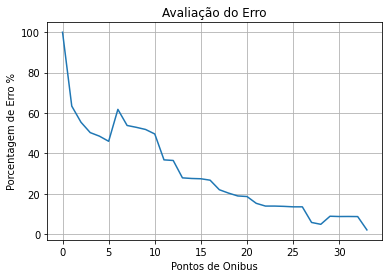

In [ ]:
plt.plot(Erros)
plt.title('Avaliação do Erro')
plt.xlabel('Pontos de Onibus')
plt.ylabel('Porcentagem de Erro %')
plt.grid()
plt.show()

In [ ]:
agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento_junho.pivot(index= 'PontoInicial', columns='PontoFinal', values='sequence').fillna(0)

PontoFinal,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
PontoInicial,,,,,,,,,,,,,,,,,,,,,
1,0.0,75.0,35.0,0.0,10.0,35.0,20.0,5.0,5.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.0,5.0,0.0,0.0
2,0.0,0.0,5.0,0.0,10.0,5.0,25.0,35.0,130.0,0.0,...,40.0,70.0,20.0,45.0,5.0,0.0,0.0,10.0,25.0,10.0
3,45.0,115.0,10.0,10.0,70.0,0.0,15.0,5.0,0.0,0.0,...,15.0,0.0,15.0,35.0,10.0,0.0,0.0,30.0,15.0,10.0
4,0.0,20.0,10.0,0.0,30.0,5.0,15.0,20.0,0.0,0.0,...,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,5.0,25.0
5,0.0,90.0,5.0,0.0,0.0,10.0,0.0,0.0,15.0,0.0,...,0.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0
6,5.0,5.0,5.0,0.0,0.0,5.0,15.0,5.0,0.0,0.0,...,10.0,0.0,0.0,5.0,5.0,0.0,10.0,5.0,0.0,0.0
7,0.0,50.0,0.0,5.0,5.0,0.0,0.0,5.0,10.0,30.0,...,0.0,10.0,5.0,5.0,0.0,0.0,5.0,5.0,40.0,0.0
8,0.0,80.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,40.0,...,20.0,15.0,0.0,5.0,0.0,5.0,0.0,0.0,10.0,5.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,55.0,10.0,20.0,0.0,0.0,0.0,0.0,20.0,10.0


In [ ]:
agrupamento_junho = matriz_junho.groupby(['PontoInicial','PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento_junho

,PontoInicial,PontoFinal,sequence
0,1,1,8150
1,1,2,3300
2,1,3,335
3,1,4,1185
4,2,1,2770
5,2,2,2180
6,2,3,220
7,2,4,365
8,3,1,440
9,3,2,575


In [ ]:
matriz_junho_agrupada

index_col  device_id  periodo  dataInicio  \
day PontoInicial PontoFinal                                              
1   1            11                  1          5        5           5   
                 31                  2         10       10          10   
    2            8                   2         10       10          10   
                 11                  2         10       10          10   
                 20                  3         15       15          15   
...                                ...        ...      ...         ...   
30  30           14                  2         10       10          10   
                 26                  1          5        5           5   
                 30                  1          5        5           5   
    32           16                  1          5        5           5   
    33           32                  1          5        5           5   

                             dataFim  sequence  distance(m)  duration(s)  \
day PontoInicial PontoFinal                                                
1   1            11                5         5            5            5   
                 31               10        10           10           10   
    2            8                10        10           10           10   
                 11               10        10           10           10   
                 20               15        15           15           15   
...                              ...       ...          ...          ...   
30  30           14               10        10           10           10   
                 26                5         5            5            5   
                 30                5         5            5            5   
    32           16                5         5            5            5   
    33           32                5         5            5            5   

                             latitudeI  longitudeI  latitudeF  longitudeF  \
day PontoInicial PontoFinal                                                 
1   1            11                  5           5          5           5   
                 31                 10          10         10          10   
    2            8                  10          10         10          10   
                 11                 10          10         10          10   
                 20                 15          15         15          15   
...                                ...         ...        ...         ...   
30  30           14                 10          10         10          10   
                 26                  5           5          5           5   
                 30                  5           5          5           5   
    32           16                  5           5          5           5   
    33           32                  5           5          5           5   

                             OrdemSaida  OrdemChegada  dist_x  dist_y  
day PontoInicial PontoFinal                                            
1   1            11                   5             5       5       5  
                 31                  10            10      10      10  
    2            8                   10            10      10      10  
                 11                  10            10      10      10  
                 20                  15            15      15      15  
...                                 ...           ...     ...     ...  
30  30           14                  10            10      10      10  
                 26                   5             5       5       5  
                 30                   5             5       5       5  
    32           16                   5             5       5       5  
    33           32                   5             5       5       5  

[2325 rows x 16 columns]